## Step 6: Extract topographic surface $S(d,u,v)$ given the topographic volume $V(d,u,v)$ space

Using the topographic volume space $V(d,u,v)$ constructed from step 5 we can readily extract the corresponding topographic surface $S(d,u,v)$ of the input surface by mapping the binary segmentation of $S(x,y,z)$ into topography space and applying surface meshing.

### Load $V(d,u,v)$, the binary cell segmentation and create an analysis save folder

We assume the user has worked through step 5 which generated the topographic volume space $V(d,u,v)$ in the folder `example_results/bleb_example/step5_topographic_space`. We also need the original image in the folder `example_data/img` and its binary segmentation in `example_data/step0_cell_segmentation`. 

In [1]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import skimage.io as skio 
import scipy.io as spio

# example cell used
imgfolder = 'example_data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step6_topographic_surface_mesh')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.

"""
Loading
"""
# original image
img_file = 'example_data/img/%s.tif' %(basefname)
img = skio.imread(img_file)


# binary segmentation
img_folder = 'example_results/%s/step0_cell_segmentation' %(basefname)
binary_file = os.path.join(img_folder, 
                            '%s_binary_seg.tif' %(basefname)) 
binary_img = skio.imread(binary_file)>0

# load the pre-computed topographic space, V(d,u,v)
topography_folder = 'example_results/%s/step5_topographic_space' %(basefname)
topography_file = os.path.join(topography_folder, 
                       'topographic_volume_space.mat')
topography_obj = spio.loadmat(topography_file) # reads the .mat like a python dictionary. 
topographic_coordinates = topography_obj['topographic_map'].copy()

### Map binary segmentation $I(V(x,y,z))$ into the topographic volume space $V(d,u,v)$

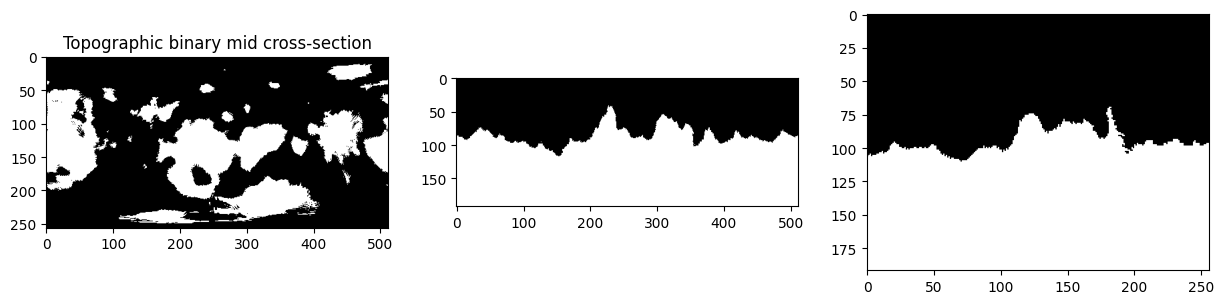

In [2]:
# convert binary to float and use linear interpolation to map the binary segmentation into topographic space
import unwrap3D.Image_Functions.image as image_fn
import pylab as plt 

topographic_binary = np.uint16(image_fn.map_intensity_interp3(topographic_coordinates.reshape(-1,3), 
                                                       grid_shape=img.shape, 
                                                       I_ref=binary_img*1.))
topographic_binary = topographic_binary.reshape(topographic_coordinates.shape[:-1])
topography_size = topographic_binary.shape[:3]

# visualize the mid cross sections of topographic and original cartesian.
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Topographic binary mid cross-section')
plt.imshow(np.rot90(topographic_binary[topography_size[0]//2,:,:],2), cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(topographic_binary[:,topography_size[1]//2,:],2), cmap='gray')
plt.subplot(133)
plt.imshow(np.rot90(topographic_binary[:,:,topography_size[2]//2],2), cmap='gray')
plt.show()


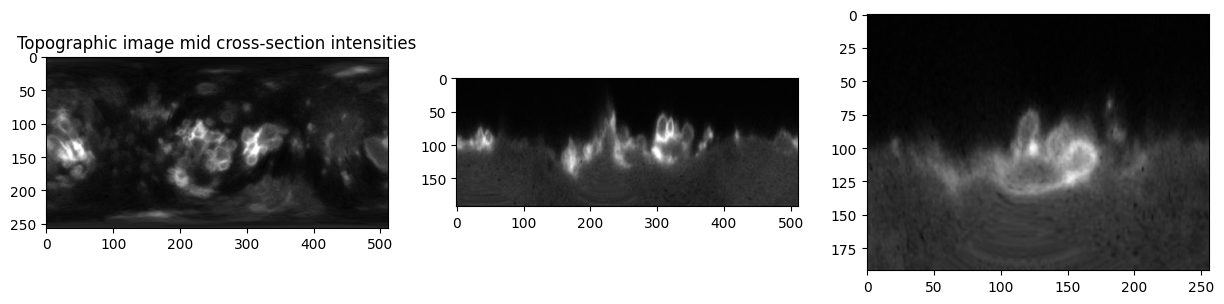

In [3]:
# we map also the image intensities for comparison

topographic_I = np.uint16(image_fn.map_intensity_interp3(topographic_coordinates.reshape(-1,3), 
                                                       grid_shape=img.shape, 
                                                       I_ref=img))
topographic_I = topographic_I.reshape(topographic_coordinates.shape[:-1])

# visualize the mid cross sections of topographic and original cartesian.
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Topographic image mid cross-section intensities')
plt.imshow(np.rot90(topographic_I[topography_size[0]//2,:,:],2), cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(topographic_I[:,topography_size[1]//2,:],2), cmap='gray')
plt.subplot(133)
plt.imshow(np.rot90(topographic_I[:,:,topography_size[2]//2],2), cmap='gray')
plt.show()


### Mesh the topographic binary segmentation to obtain topographic surface mesh $S(d,u,v)$

In [4]:
# we mesh and keep the largest connected component
topographic_mesh = meshtools.marching_cubes_mesh_binary(topographic_binary,   
                                                        presmooth=1., # applies a presmooth
                                                        contourlevel=.5,
                                                        keep_largest_only=True, # we want the largest connected component 
                                                        remesh=True,
                                                        remesh_method='pyacvd', 
                                                        remesh_samples=.5, # remeshing with a target #vertices = 50% of original
                                                        predecimate=True, # this applies quadric mesh simplication to remove very small edges before remeshing
                                                        min_mesh_size=60000,
                                                        upsamplemethod='loop') # upsample the mesh if after the simplification and remeshing < min_mesh_size  


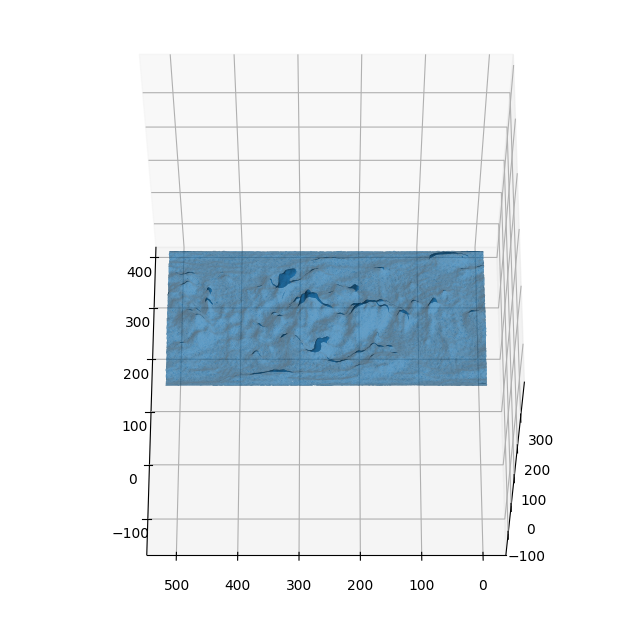

In [13]:
import unwrap3D.Visualisation.plotting as plotting

# plot the mesh - not very exciting at the moment due to lack of colors. 
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,8))
ax.set_box_aspect(aspect = (1,1,1))
ax.plot_trisurf(topographic_mesh.vertices[...,1], 
                topographic_mesh.vertices[...,2], 
                topographic_mesh.vertices[...,0],
                triangles=topographic_mesh.faces)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()


### Map surface curvature and molecular intensities onto topographic surface mesh $S(d,u,v)$

We can compute the surface curvature and molecular intensities for $S(d,u,v)$ directly in Cartesian space thanks to the bijective mapping.

To do so, we map the vertices of $S(d,u,v)$ first into Cartesian $(x,y,z)$ space.

In [14]:
import unwrap3D.Analysis_Functions.topography as topo_tools

topography_verts_xyz = topo_tools.uv_depth_pts3D_to_xyz_pts3D( topographic_mesh.vertices, 
                                                               topographic_coordinates)

In [15]:
import unwrap3D.Segmentation.segmentation as segmentation
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm 

# Compute the continuous mean curvature from the binary cell segmentation as for S(x,y,z) 
H_binary, H_sdf_vol_normal, H_sdf_vol = segmentation.mean_curvature_binary(binary_img, 
                                                                           smooth=3, 
                                                                           mask=False) # if mask=True, only the curvature of a thin shell (+/-smooth) around the binary segmentation is returned. 

# interpolate the value onto the topographic mesh.
topo_surf_H = image_fn.map_intensity_interp3(topography_verts_xyz, 
                                            grid_shape= H_binary.shape, 
                                            I_ref= H_binary, 
                                            method='linear', 
                                            cast_uint8=False)

# we generate colors from the mean curvature 
topo_surf_H_colors = vol_colors.get_colors(topo_surf_H/.104, # 0.104 is the voxel resolution -> this converts to um^-1 
                                          colormap=cm.Spectral_r, 
                                          vmin=-1., 
                                          vmax=1.) # colormap H with lower and upper limit of -1, 1 um^-1. 

# set the vertex colors to the computed mean curvature color
topographic_mesh.visual.vertex_colors = np.uint8(255*topo_surf_H_colors[...,:3]) 

# save the mesh for viewing in an external program such as meshlab which offers much better rendering capabilities
tmp = topographic_mesh.export(os.path.join(savefolder, 
                                           'curvature_topographic_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.

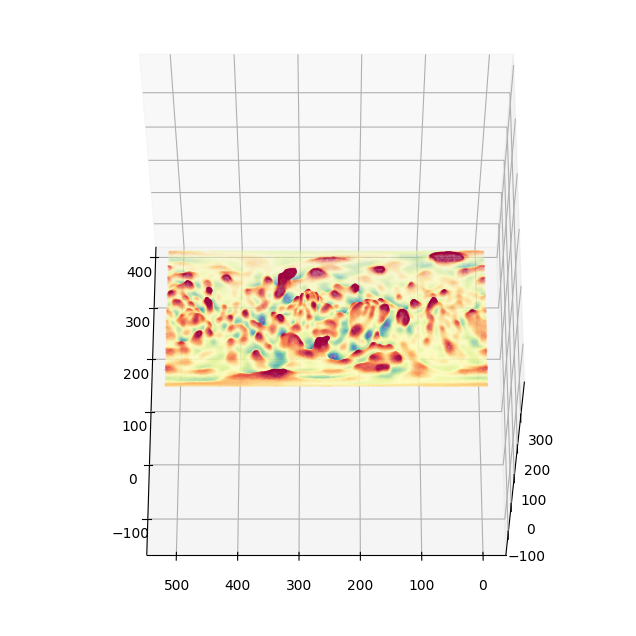

In [17]:
# visualise the topographic surface with curvature colors
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,8))
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(topographic_mesh.vertices[...,1], 
            topographic_mesh.vertices[...,2], 
            topographic_mesh.vertices[...,0],
            c = topo_surf_H_colors, s=0.1)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()

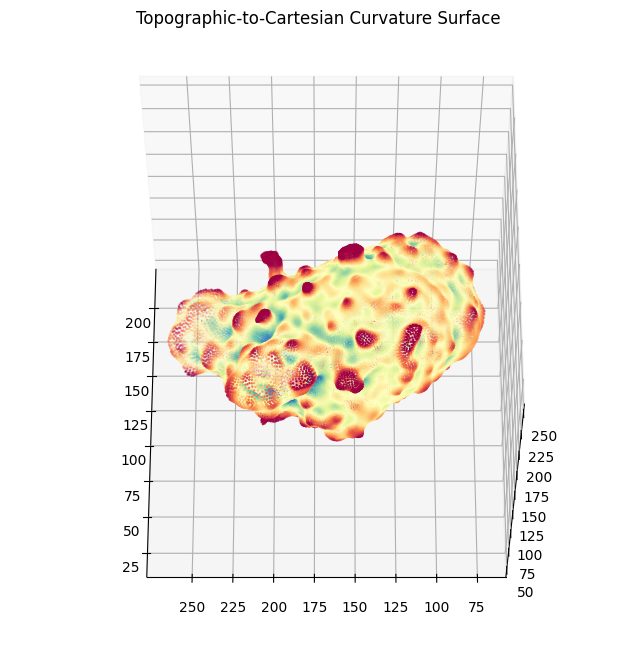

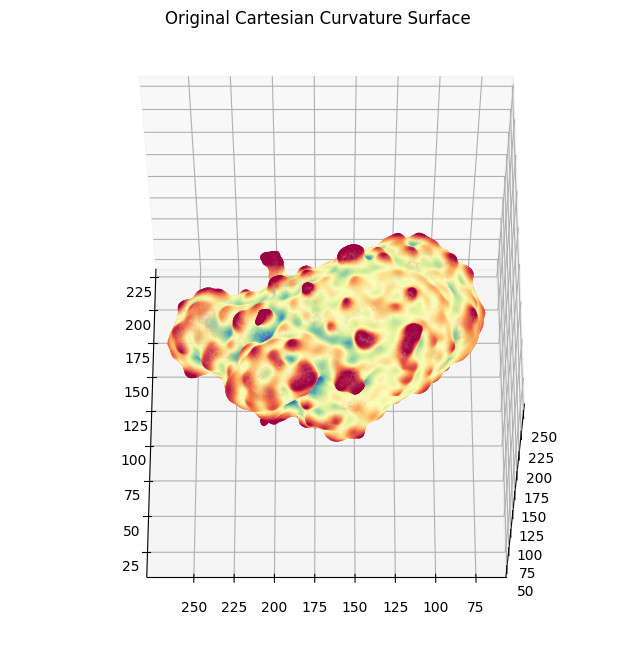

In [18]:
# we can plot this with the original surface mesh for a side-by-side comparison! - can see they are almost identical. 


# 1. Topographic-to-Cartesian surface
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,8))
plt.title('Topographic-to-Cartesian Curvature Surface')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(topography_verts_xyz[...,2], 
            topography_verts_xyz[...,1], 
            topography_verts_xyz[...,0],
            c = topo_surf_H_colors, s=0.5) # use a larger size, as the mesh is smaller.
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()

# read in the cell segmentation surface
img_folder = 'example_results/%s/step0_cell_segmentation' %(basefname)
binary_file = os.path.join(img_folder, 
                            '%s_binary_seg.tif' %(basefname)) 
cartesian_surface_H = meshtools.read_mesh(os.path.join('example_results/%s/step0_cell_segmentation' %(basefname),
                                                      'curvature_binary_mesh_%s.obj' %(basefname)))

# 2. Original-Cartesian surface
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,8))
plt.title('Original Cartesian Curvature Surface')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(cartesian_surface_H.vertices[...,0], 
            cartesian_surface_H.vertices[...,1], 
            cartesian_surface_H.vertices[...,2],
            c = cartesian_surface_H.visual.vertex_colors[:,:3]/255., s=0.1)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()


We now map the image intensity. As before we will sample 1um along the steepest gradient of the signed distance transform into the cell

In [19]:
"""
Mapping the molecular intensity up to 1um onto the topographic surface
"""

# create the surface mesh, of the topographic mapped back into Cartesian 3D. 
topo_cartesian_mesh = meshtools.create_mesh(vertices=topography_verts_xyz, # just change the vertices, the faces does not change.
                                            faces=topographic_mesh.faces)

n_samples = 1./ .104 # total number of steps
stepsize = 0.5 # voxels

# run the active contour cMCF to get the coordinates at different depths into the cell according to the external image gradient given by the gradient of the signed distance function.
v_depth = meshtools.parametric_mesh_constant_img_flow(topo_cartesian_mesh, 
                                                      external_img_gradient = H_sdf_vol_normal.transpose(1,2,3,0), 
                                                      niters=int(n_samples/stepsize), 
                                                      deltaL=5e-5, # delta which controls the stiffness of the mesh
                                                      step_size=stepsize, 
                                                      method='implicit', # this specifies the cMCF solver.
                                                      conformalize=True) # ensure we use the cMCF Laplacian



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  1.92it/s]


In [20]:
# get the intensities at the sampled depth coordinates. 
topo_v_depth_I = image_fn.map_intensity_interp3(v_depth.transpose(0,2,1).reshape(-1,3), 
                                            img.shape, 
                                            I_ref=img)
topo_v_depth_I = topo_v_depth_I.reshape(-1,v_depth.shape[-1]) # matrix reshaping into a nicer shape. 

# postprocess to check the total distance from the surface does not exceed the desired and replace any nans.  
dist_v_depth0 = np.linalg.norm(v_depth - v_depth[...,0][...,None], axis=1)
valid_I = dist_v_depth0<=n_samples
topo_v_depth_I[valid_I == 0 ] = np.nan # replace with nans

# compute the mean sampled intensity which will be taken as the surface intensity. 
topo_surf_intensity_img_raw = np.nanmean(topo_v_depth_I, axis=1)
topo_surf_intensity_img_raw[np.isnan(topo_surf_intensity_img_raw)] = 0

"""
# for visualization, we find the intensity range to be more pleasing if clipped to between the 1st and 99th percentile. 
# NOTE: we need to match the original intensity statistics to have identical visualisation ! 
"""
import scipy.io as spio 

curvature_intensity_stats = spio.loadmat(os.path.join('example_results/%s/step0_cell_segmentation' %(basefname),
                                                      '%s_surface_curvature_intensity_stats' %(basefname)))
I_min = np.percentile(curvature_intensity_stats['surf_intensity'][0],1)
I_max = np.percentile(curvature_intensity_stats['surf_intensity'][0],99)

topo_surf_intensity_img_raw_colors = vol_colors.get_colors(topo_surf_intensity_img_raw, 
                                                      colormap=cm.RdYlBu_r,   
                                                      vmin=I_min, 
                                                      vmax=I_max)

# create a new topograpphic surface mesh, now with the PI3K molecular signal colors. 
topographic_surf_mesh_colors = meshtools.create_mesh(vertices=topographic_mesh.vertices,
                                                      faces=topographic_mesh.faces, 
                                                      vertex_colors=np.uint8(255*topo_surf_intensity_img_raw_colors[...,:3])) 
tmp = topographic_surf_mesh_colors.export(os.path.join(savefolder, 
                                                'PI3K_topographic_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.


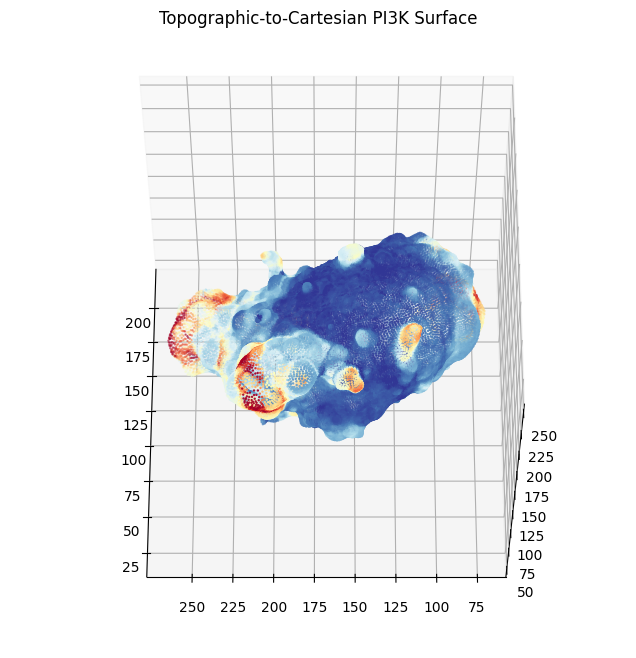

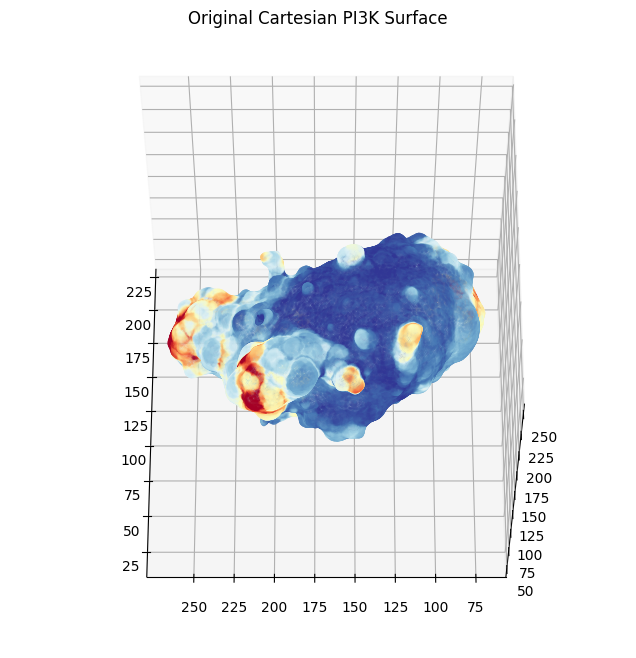

In [12]:
# we can plot this with the original surface mesh for a side-by-side comparison of the sampled molecular intensity! - can see they are almost identical. 


# 1. Topographic-to-Cartesian surface PI3K intensity
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,8))
plt.title('Topographic-to-Cartesian PI3K Surface')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(topography_verts_xyz[...,2], 
            topography_verts_xyz[...,1], 
            topography_verts_xyz[...,0],
            c = topo_surf_intensity_img_raw_colors, s=0.5) # use a larger size, as the mesh is smaller.
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()

# read in the cell segmentation surface
img_folder = 'example_results/%s/step0_cell_segmentation' %(basefname)
binary_file = os.path.join(img_folder, 
                            '%s_binary_seg.tif' %(basefname)) 
cartesian_surface_PI3K = meshtools.read_mesh(os.path.join('example_results/%s/step0_cell_segmentation' %(basefname),
                                                      'PI3K_binary_mesh_%s.obj' %(basefname)))

# 2. Original-Cartesian surface
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,8))
plt.title('Original Cartesian PI3K Surface')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(cartesian_surface_PI3K.vertices[...,0], 
            cartesian_surface_PI3K.vertices[...,1], 
            cartesian_surface_PI3K.vertices[...,2],
            c = cartesian_surface_PI3K.visual.vertex_colors[:,:3]/255., s=0.1)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()

## We have now finished the 6 steps to map an input surface $S(x,y,z)$ into the different u-Unwrap3D proposed representations. Please check the other notebooks for specific topics.